# Phân tích Clustering Toàn Diện

Notebook này bổ sung các thí nghiệm so sánh để hoàn thành báo cáo Data Mining:
- So sánh **Apriori vs FP-Growth**
- So sánh **Binary vs Weighted** features
- So sánh **Top-K** khác nhau (50, 100, 200)
- **Cluster profiling** với top rules
- **PCA scatter** visualization

In [1]:
# Cell 2 - Setup
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Project root
cwd = os.getcwd()
project_root = os.path.abspath("..") if os.path.basename(cwd) == "notebooks" else cwd
sys.path.append(os.path.join(project_root, "src"))

from cluster_library import RuleBasedCustomerClusterer

# Paths
CLEANED_DATA_PATH = os.path.join(project_root, "data/processed/cleaned_uk_data.csv")
RULES_APRIORI_PATH = os.path.join(project_root, "data/processed/rules_apriori_filtered.csv")
RULES_FPGROWTH_PATH = os.path.join(project_root, "data/processed/rules_fpgrowth_filtered.csv")
OUTPUT_DIR = os.path.join(project_root, "data/processed")

In [2]:
# Cell 3 - Load data
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(f"Loaded {len(df_clean):,} transactions")

# Initialize clusterer
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print(f"Customer × Item: {customer_item_bool.shape}")

C:\Users\nguye\AppData\Local\Temp\ipykernel_10540\3743392342.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


Loaded 485,123 transactions
Customer × Item: (3921, 4007)


In [3]:
# Helper utilities: feature matrix + silhouette search

def build_feature_matrix(clusterer, weighting="none", use_rfm=True, rfm_scale=True, rule_scale=False):
    """Create a customer-level feature DataFrame (rules + optional RFM) plus raw RFM for profiling."""
    X, meta = clusterer.build_final_features(
        weighting=weighting,
        use_rfm=use_rfm,
        rfm_scale=rfm_scale,
        rule_scale=rule_scale,
    )

    n_rules = clusterer.rules_df_.shape[0] if clusterer.rules_df_ is not None else 0
    rule_cols = [f"rule_{i}" for i in range(n_rules)]
    cols = rule_cols + (["Recency", "Frequency", "Monetary"] if use_rfm else [])

    feature_df = pd.DataFrame(
        X,
        index=clusterer.customers_,
        columns=cols
    )

    meta_rfm = meta.set_index(clusterer.customer_col)
    # Align to the same ordering as the feature matrix
    meta_rfm = meta_rfm.loc[feature_df.index]
    return feature_df, meta_rfm


def silhouette_table(feature_matrix, k_min=2, k_max=10, random_state=42):
    """Compute silhouette scores for K in [k_min, k_max]."""
    X = feature_matrix.values if hasattr(feature_matrix, "values") else feature_matrix
    return RuleBasedCustomerClusterer.choose_k_by_silhouette(
        X,
        k_min=k_min,
        k_max=k_max,
        random_state=random_state,
    )


## 1. Grid Search: So sánh hệ thống

Chạy grid search trên các tham số:
- **Rules Source**: Apriori vs FP-Growth
- **Weighting**: none (binary) vs lift vs lift×confidence
- **Top-K**: 50, 100, 200

In [4]:
# Grid Search: WEIGHTING x TOP_K x RULES_SOURCE
results = []

# Parameters to test
WEIGHTINGS = ["none", "lift", "lift_x_conf"]
TOP_KS = [50, 100, 200]
RULES_SOURCES = [
    ("Apriori", RULES_APRIORI_PATH),
    ("FP-Growth", RULES_FPGROWTH_PATH)
]

for (source_name, rules_path), weighting, top_k in product(RULES_SOURCES, WEIGHTINGS, TOP_KS):
    try:
        # Load rules
        rules_df = clusterer.load_rules(
            rules_csv_path=rules_path,
            top_k=top_k,
            sort_by="lift"
        )
        
        # Build features (rules + RFM)
        feature_matrix_df, _ = build_feature_matrix(
            clusterer,
            weighting=weighting,
            use_rfm=True,
            rfm_scale=True,
            rule_scale=False,
        )
        
        # Find best K
        sil_df_tmp = silhouette_table(
            feature_matrix_df,
            k_min=2,
            k_max=10,
            random_state=42
        )
        best_row = sil_df_tmp.loc[sil_df_tmp["silhouette"].idxmax()]
        best_k = int(best_row["k"].item() if hasattr(best_row["k"], "item") else best_row["k"])
        best_sil = float(best_row["silhouette"].item() if hasattr(best_row["silhouette"], "item") else best_row["silhouette"])
        
        results.append({
            "Rules Source": source_name,
            "Weighting": weighting,
            "Top-K": top_k,
            "Best K": best_k,
            "Silhouette": round(best_sil, 4)
        })
        print(f"[OK] {source_name} | {weighting:12} | Top-{top_k:3} -> K={best_k}, Sil={best_sil:.4f}")
        
    except Exception as e:
        print(f"[ERR] {source_name} | {weighting} | Top-{top_k}: {e}")

# Summary table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values("Silhouette", ascending=False).reset_index(drop=True)
print("\n=== SO SÁNH HỆ THỐNG ===")
display(comparison_df)
comparison_df.to_csv(os.path.join(OUTPUT_DIR, "clustering_comparison.csv"), index=False)

[OK] Apriori | none         | Top- 50 -> K=4, Sil=0.6845
[OK] Apriori | none         | Top-100 -> K=4, Sil=0.4830
[OK] Apriori | none         | Top-200 -> K=8, Sil=0.2856
[OK] Apriori | lift         | Top- 50 -> K=10, Sil=0.9933
[OK] Apriori | lift         | Top-100 -> K=2, Sil=0.9223
[OK] Apriori | lift         | Top-200 -> K=2, Sil=0.8541
[OK] Apriori | lift_x_conf  | Top- 50 -> K=10, Sil=0.9929
[OK] Apriori | lift_x_conf  | Top-100 -> K=2, Sil=0.9356
[OK] Apriori | lift_x_conf  | Top-200 -> K=2, Sil=0.8914
[OK] FP-Growth | none         | Top- 50 -> K=4, Sil=0.6845
[OK] FP-Growth | none         | Top-100 -> K=4, Sil=0.4830
[OK] FP-Growth | none         | Top-200 -> K=8, Sil=0.2856
[OK] FP-Growth | lift         | Top- 50 -> K=10, Sil=0.9933
[OK] FP-Growth | lift         | Top-100 -> K=2, Sil=0.9223
[OK] FP-Growth | lift         | Top-200 -> K=2, Sil=0.8541
[OK] FP-Growth | lift_x_conf  | Top- 50 -> K=10, Sil=0.9929
[OK] FP-Growth | lift_x_conf  | Top-100 -> K=2, Sil=0.9356
[OK] FP-Gro

,Rules Source,Weighting,Top-K,Best K,Silhouette
0,FP-Growth,lift,50,10,0.9933
1,Apriori,lift,50,10,0.9933
2,FP-Growth,lift_x_conf,50,10,0.9929
3,Apriori,lift_x_conf,50,10,0.9929
4,Apriori,lift_x_conf,100,2,0.9356
5,FP-Growth,lift_x_conf,100,2,0.9356
6,FP-Growth,lift,100,2,0.9223
7,Apriori,lift,100,2,0.9223
8,FP-Growth,lift_x_conf,200,2,0.8914
9,Apriori,lift_x_conf,200,2,0.8914


## 2. Best Configuration - Chi tiết Silhouette

Chọn cấu hình tốt nhất và phân tích chi tiết silhouette score theo K.

In [5]:
# Chọn config tốt nhất từ grid search hoặc dùng config mặc định
if len(comparison_df) > 0:
    best_config = comparison_df.iloc[0]
    print(f"Best config: {best_config['Rules Source']} | {best_config['Weighting']} | Top-{best_config['Top-K']}")
    BEST_RULES_PATH = RULES_APRIORI_PATH if best_config["Rules Source"] == "Apriori" else RULES_FPGROWTH_PATH
    BEST_WEIGHTING = best_config["Weighting"]
    BEST_TOP_K = int(best_config["Top-K"])
else:
    BEST_RULES_PATH = RULES_APRIORI_PATH
    BEST_WEIGHTING = "lift"
    BEST_TOP_K = 200

# Re-run with best config
rules_df = clusterer.load_rules(BEST_RULES_PATH, top_k=BEST_TOP_K, sort_by="lift")
feature_matrix_df, meta_rfm = build_feature_matrix(
    clusterer,
    weighting=BEST_WEIGHTING,
    use_rfm=True,
    rfm_scale=True,
    rule_scale=False,
)

print(f"\nFeature matrix shape: {feature_matrix_df.shape}")
print(f"Rules used: {len(rules_df)}")

Best config: FP-Growth | lift | Top-50

Feature matrix shape: (3921, 53)
Rules used: 50


=== SILHOUETTE TABLE ===


,k,silhouette
0,10,0.993279
1,9,0.993144
2,8,0.992677
3,7,0.992546
4,6,0.991636
5,5,0.989398
6,4,0.986798
7,2,0.986423
8,3,0.985536


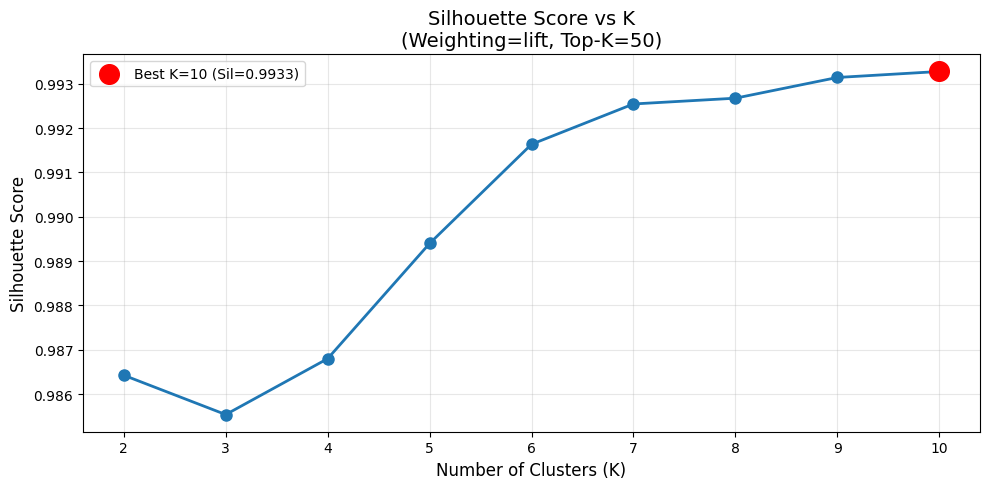


Saved: silhouette_plot.png


In [8]:
# Silhouette analysis
sil_df = silhouette_table(
    feature_matrix_df,
    k_min=2,
    k_max=10,
    random_state=42,
)

sil_df_display = sil_df.sort_values("silhouette", ascending=False)
print("=== SILHOUETTE TABLE ===")
display(sil_df_display)

# Plot silhouette
sil_df_plot = sil_df.sort_values("k")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sil_df_plot["k"], sil_df_plot["silhouette"], marker="o", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (K)", fontsize=12)
ax.set_ylabel("Silhouette Score", fontsize=12)
ax.set_title(f"Silhouette Score vs K\n(Weighting={BEST_WEIGHTING}, Top-K={BEST_TOP_K})", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(2, 11))

# Highlight best K
best_row = sil_df.loc[sil_df["silhouette"].idxmax()]
best_k = int(best_row["k"].item() if hasattr(best_row["k"], "item") else best_row["k"])
best_sil = float(best_row["silhouette"].item() if hasattr(best_row["silhouette"], "item") else best_row["silhouette"])
ax.scatter([best_k], [best_sil], s=200, c="red", zorder=5, label=f"Best K={best_k} (Sil={best_sil:.4f})")
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "silhouette_plot.png"), dpi=150, bbox_inches="tight")
plt.show()
print(f"\nSaved: silhouette_plot.png")

## 3. Fit KMeans với Best K

In [10]:
# Fit final model với best K
print(f"Fitting KMeans with K = {best_k}")

labels = clusterer.fit_kmeans(feature_matrix_df.values, n_clusters=best_k, random_state=42)

# Cluster distribution
cluster_counts = pd.Series(labels).value_counts().sort_index()
print("\n=== CLUSTER DISTRIBUTION ===")
for cluster_id, count in cluster_counts.items():
    pct = count / len(labels) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")

Fitting KMeans with K = 10

=== CLUSTER DISTRIBUTION ===
  Cluster 0: 3,788 customers (96.6%)
  Cluster 1: 99 customers (2.5%)
  Cluster 2: 6 customers (0.2%)
  Cluster 3: 7 customers (0.2%)
  Cluster 4: 3 customers (0.1%)
  Cluster 5: 7 customers (0.2%)
  Cluster 6: 4 customers (0.1%)
  Cluster 7: 3 customers (0.1%)
  Cluster 8: 3 customers (0.1%)
  Cluster 9: 1 customers (0.0%)


## 4. Cluster Profiling: RFM Stats + Top Rules

Phân tích từng cluster theo:
- **RFM Statistics**: Recency, Frequency, Monetary trung bình
- **Top Rules**: Các rule-features kích hoạt nhiều nhất trong cluster

In [11]:
def get_cluster_profiles(feature_matrix, labels, rules_df, meta_rfm=None, top_n_rules=10):
    """Profiling mỗi cluster: RFM stats + top rules kích hoạt nhiều nhất"""
    
    profiles = []
    rule_cols = [c for c in feature_matrix.columns if c.startswith("rule_")]
    rfm_source = meta_rfm.loc[feature_matrix.index] if meta_rfm is not None else feature_matrix
    
    for cluster_id in sorted(set(labels)):
        mask = labels == cluster_id
        cluster_features = feature_matrix.loc[mask]
        
        # Basic stats
        profile = {
            "Cluster": cluster_id,
            "Size": int(mask.sum()),
            "Size_pct": f"{mask.sum() / len(labels) * 100:.1f}%",
        }
        
        # RFM stats (use raw RFM if available)
        rfm_cols = ["Recency", "Frequency", "Monetary"]
        for col in rfm_cols:
            if col in rfm_source.columns:
                profile[f"{col}_mean"] = round(rfm_source.loc[mask, col].mean(), 2)
        
        # Top rules (highest activation rate in this cluster)
        if len(rule_cols) > 0:
            rule_activation = (cluster_features[rule_cols] > 0).mean().sort_values(ascending=False)
            top_rules_idx = rule_activation.head(top_n_rules)
            
            top_rules_info = []
            for rule_col, activation in top_rules_idx.items():
                rule_idx = int(rule_col.replace("rule_", ""))
                if rule_idx < len(rules_df):
                    rule_str = rules_df.iloc[rule_idx].get("rule_str", f"Rule {rule_idx}")
                    top_rules_info.append({
                        "rule_col": rule_col,
                        "rule_str": rule_str,
                        "activation": activation
                    })
            
            profile["top_rules"] = top_rules_info
        
        profiles.append(profile)
    
    return profiles

# Get profiles
profiles = get_cluster_profiles(feature_matrix_df, labels, rules_df, meta_rfm=meta_rfm, top_n_rules=10)

# Display RFM summary table
print("=== CLUSTER PROFILING: RFM STATISTICS ===\n")
rfm_summary = []
for p in profiles:
    rfm_summary.append({
        "Cluster": p["Cluster"],
        "Size": p["Size"],
        "Size %": p["Size_pct"],
        "Recency (mean)": p.get("Recency_mean", "N/A"),
        "Frequency (mean)": p.get("Frequency_mean", "N/A"),
        "Monetary (mean)": p.get("Monetary_mean", "N/A"),
    })
rfm_df = pd.DataFrame(rfm_summary)
display(rfm_df)

=== CLUSTER PROFILING: RFM STATISTICS ===



,Cluster,Size,Size %,Recency (mean),Frequency (mean),Monetary (mean)
0,0,3788,96.6%,93.26,4.04,1808.41
1,1,99,2.5%,59.48,25.38,21284.50
2,2,6,0.2%,37.17,9.83,3483.87
3,3,7,0.2%,82.29,3.57,1320.65
4,4,3,0.1%,92.00,3.00,521.39
5,5,7,0.2%,73.43,4.71,1538.35
6,6,4,0.1%,77.50,3.50,1242.10
7,7,3,0.1%,28.00,11.00,3883.74
8,8,3,0.1%,9.33,7.33,2774.11
9,9,1,0.0%,277.00,1.00,391.52


In [12]:
# Display top rules per cluster
print("=== TOP RULES PER CLUSTER ===\n")

for p in profiles:
    cluster_id = p["Cluster"]
    size_pct = p["Size_pct"]
    print(f"{'='*60}")
    print(f"CLUSTER {cluster_id} ({p['Size']:,} customers, {size_pct})")
    print(f"{'='*60}")
    print(f"  RFM: Recency={p.get('Recency_mean', 'N/A')}, Frequency={p.get('Frequency_mean', 'N/A')}, Monetary={p.get('Monetary_mean', 'N/A')}")
    print(f"\n  Top 5 Rules:")
    
    if "top_rules" in p:
        for i, rule_info in enumerate(p["top_rules"][:5], 1):
            act_pct = rule_info["activation"] * 100
            print(f"    {i}. {rule_info['rule_str']}")
            print(f"       Activation: {act_pct:.1f}%")
    print()

=== TOP RULES PER CLUSTER ===

CLUSTER 0 (3,788 customers, 96.6%)
  RFM: Recency=93.26, Frequency=4.04, Monetary=1808.41

  Top 5 Rules:
    1. HERB MARKER BASIL → HERB MARKER ROSEMARY
       Activation: 0.1%
    2. HERB MARKER MINT → HERB MARKER PARSLEY
       Activation: 0.1%
    3. HERB MARKER MINT → HERB MARKER CHIVES 
       Activation: 0.1%
    4. HERB MARKER BASIL → HERB MARKER PARSLEY
       Activation: 0.1%
    5. HERB MARKER BASIL, HERB MARKER MINT → HERB MARKER PARSLEY
       Activation: 0.0%

CLUSTER 1 (99 customers, 2.5%)
  RFM: Recency=59.48, Frequency=25.38, Monetary=21284.5

  Top 5 Rules:
    1. HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HERB MARKER THYME
       Activation: 100.0%
    2. HERB MARKER MINT, HERB MARKER THYME → HERB MARKER ROSEMARY
       Activation: 100.0%
    3. HERB MARKER MINT, HERB MARKER THYME → HERB MARKER PARSLEY
       Activation: 100.0%
    4. HERB MARKER PARSLEY, HERB MARKER THYME → HERB MARKER ROSEMARY
       Activation: 100.0%
    5. HERB MA

## 5. PCA 2D Scatter Visualization

PCA Variance Explained: PC1=93.29%, PC2=1.87%, Total=95.17%


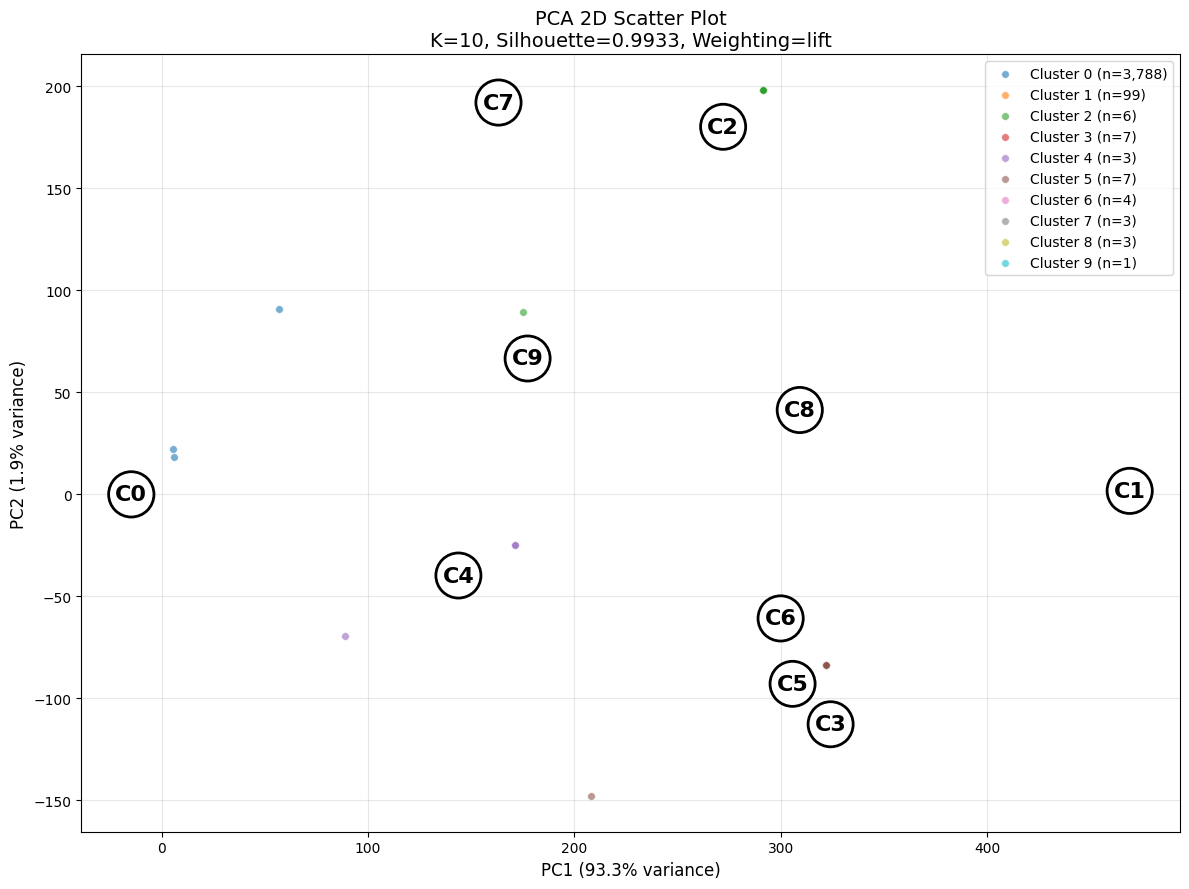


Saved: pca_scatter.png


In [13]:
# PCA Projection
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(feature_matrix_df.values)

# Variance explained
var_explained = pca.explained_variance_ratio_
print(f"PCA Variance Explained: PC1={var_explained[0]:.2%}, PC2={var_explained[1]:.2%}, Total={sum(var_explained):.2%}")

# Plot
fig, ax = plt.subplots(figsize=(12, 9))

# Define colors for clusters
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

for cluster_id in sorted(set(labels)):
    mask = labels == cluster_id
    ax.scatter(
        coords_2d[mask, 0], 
        coords_2d[mask, 1], 
        c=[colors[cluster_id]], 
        label=f"Cluster {cluster_id} (n={mask.sum():,})",
        alpha=0.6, 
        s=30,
        edgecolors='white',
        linewidth=0.5
    )

# Annotate cluster centers
for cluster_id in sorted(set(labels)):
    mask = labels == cluster_id
    cx, cy = coords_2d[mask, 0].mean(), coords_2d[mask, 1].mean()
    ax.annotate(
        f"C{cluster_id}", 
        (cx, cy), 
        fontsize=16, 
        fontweight="bold",
        ha="center", 
        va="center",
        bbox=dict(boxstyle="circle,pad=0.3", facecolor="white", edgecolor="black", linewidth=2)
    )

ax.set_xlabel(f"PC1 ({var_explained[0]:.1%} variance)", fontsize=12)
ax.set_ylabel(f"PC2 ({var_explained[1]:.1%} variance)", fontsize=12)
ax.set_title(f"PCA 2D Scatter Plot\nK={best_k}, Silhouette={best_sil:.4f}, Weighting={BEST_WEIGHTING}", fontsize=14)
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pca_scatter.png"), dpi=200, bbox_inches="tight")
plt.show()

print(f"\nSaved: pca_scatter.png")

## 6. Export Results

In [14]:
# Export customer labels
output_labels = pd.DataFrame({
    "CustomerID": feature_matrix_df.index,
    "Cluster": labels
})
output_labels.to_csv(os.path.join(OUTPUT_DIR, "customer_cluster_labels.csv"), index=False)

# Export cluster profiles
profile_export = []
for p in profiles:
    row = {
        "Cluster": p["Cluster"],
        "Size": p["Size"],
        "Size_pct": p["Size_pct"],
        "Recency_mean": p.get("Recency_mean", None),
        "Frequency_mean": p.get("Frequency_mean", None),
        "Monetary_mean": p.get("Monetary_mean", None),
    }
    # Add top 5 rules as columns
    if "top_rules" in p:
        for i, rule_info in enumerate(p["top_rules"][:5], 1):
            row[f"Top_Rule_{i}"] = rule_info["rule_str"]
            row[f"Top_Rule_{i}_Activation"] = f"{rule_info['activation']*100:.1f}%"
    profile_export.append(row)

profile_export_df = pd.DataFrame(profile_export)
profile_export_df.to_csv(os.path.join(OUTPUT_DIR, "cluster_profiles_detailed.csv"), index=False)

# Export silhouette table
sil_df.to_csv(os.path.join(OUTPUT_DIR, "silhouette_table.csv"), index=False)

print("="*60)
print("FILES EXPORTED:")
print("="*60)
print(f"  1. {OUTPUT_DIR}/clustering_comparison.csv")
print(f"  2. {OUTPUT_DIR}/customer_cluster_labels.csv")
print(f"  3. {OUTPUT_DIR}/cluster_profiles_detailed.csv")
print(f"  4. {OUTPUT_DIR}/silhouette_table.csv")
print(f"  5. {OUTPUT_DIR}/silhouette_plot.png")
print(f"  6. {OUTPUT_DIR}/pca_scatter.png")
print("="*60)

FILES EXPORTED:
  1. c:\Datamining\shop_cluster\data/processed/clustering_comparison.csv
  2. c:\Datamining\shop_cluster\data/processed/customer_cluster_labels.csv
  3. c:\Datamining\shop_cluster\data/processed/cluster_profiles_detailed.csv
  4. c:\Datamining\shop_cluster\data/processed/silhouette_table.csv
  5. c:\Datamining\shop_cluster\data/processed/silhouette_plot.png
  6. c:\Datamining\shop_cluster\data/processed/pca_scatter.png


## 7. Tóm tắt kết quả cho Báo cáo

Cell này tổng hợp tất cả thông tin cần thiết cho báo cáo Data Mining.

## 8. So Sánh Thuật Toán Clustering (Nâng Cao)

So sánh K-Means với các thuật toán clustering khác:
- **Agglomerative Clustering**: Hierarchical clustering, không cần chỉ định K trước
- **DBSCAN**: Density-based, tự động phát hiện outliers

Metrics đánh giá:
- **Silhouette Score**: Cao hơn = cluster tách biệt rõ hơn
- **Davies-Bouldin Index (DBI)**: Thấp hơn = cluster tốt hơn  
- **Calinski-Harabasz Index (CH)**: Cao hơn = cluster tốt hơn

In [16]:
# So sánh các thuật toán clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Chuẩn bị dữ liệu
X = feature_matrix_df.values

# Dictionary lưu kết quả
algo_results = []

# 1. K-Means (đã chạy)
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
algo_results.append({
    "Algorithm": "K-Means",
    "n_clusters": best_k,
    "Silhouette": silhouette_score(X, kmeans_labels),
    "Davies-Bouldin": davies_bouldin_score(X, kmeans_labels),
    "Calinski-Harabasz": calinski_harabasz_score(X, kmeans_labels),
    "Labels": kmeans_labels
})

# 2. Agglomerative Clustering với các linkage methods
for linkage in ["ward", "complete", "average"]:
    try:
        agg = AgglomerativeClustering(n_clusters=best_k, linkage=linkage)
        agg_labels = agg.fit_predict(X)
        algo_results.append({
            "Algorithm": f"Agglomerative ({linkage})",
            "n_clusters": best_k,
            "Silhouette": silhouette_score(X, agg_labels),
            "Davies-Bouldin": davies_bouldin_score(X, agg_labels),
            "Calinski-Harabasz": calinski_harabasz_score(X, agg_labels),
            "Labels": agg_labels
        })
    except Exception as e:
        print(f"Agglomerative ({linkage}) failed: {e}")

# 3. DBSCAN với các eps khác nhau
for eps in [0.5, 1.0, 2.0, 5.0, 10.0]:
    try:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        # Chỉ tính metrics nếu có ít nhất 2 cluster và không quá nhiều noise
        if n_clusters >= 2 and n_noise < len(X) * 0.9:
            # Lọc bỏ noise points để tính metrics
            mask = dbscan_labels != -1
            if mask.sum() > n_clusters:
                algo_results.append({
                    "Algorithm": f"DBSCAN (eps={eps})",
                    "n_clusters": n_clusters,
                    "Silhouette": silhouette_score(X[mask], dbscan_labels[mask]),
                    "Davies-Bouldin": davies_bouldin_score(X[mask], dbscan_labels[mask]),
                    "Calinski-Harabasz": calinski_harabasz_score(X[mask], dbscan_labels[mask]),
                    "Labels": dbscan_labels,
                    "Noise_points": n_noise
                })
    except Exception as e:
        print(f"DBSCAN (eps={eps}) failed: {e}")

# Tạo bảng so sánh
algo_comparison_df = pd.DataFrame([
    {
        "Algorithm": r["Algorithm"],
        "n_clusters": r["n_clusters"],
        "Silhouette": round(r["Silhouette"], 4),
        "Davies-Bouldin": round(r["Davies-Bouldin"], 4),
        "Calinski-Harabasz": round(r["Calinski-Harabasz"], 2),
        "Noise": r.get("Noise_points", 0)
    }
    for r in algo_results
])

print("=" * 70)
print("SO SÁNH CÁC THUẬT TOÁN CLUSTERING")
print("=" * 70)
print("\n📊 Metrics giải thích:")
print("  • Silhouette: Cao hơn tốt hơn (max = 1)")
print("  • Davies-Bouldin: Thấp hơn tốt hơn (min = 0)")
print("  • Calinski-Harabasz: Cao hơn tốt hơn")
print("\n")
display(algo_comparison_df.sort_values("Silhouette", ascending=False))

# Lưu kết quả
algo_comparison_df.to_csv(os.path.join(OUTPUT_DIR, "algorithm_comparison.csv"), index=False)

SO SÁNH CÁC THUẬT TOÁN CLUSTERING

📊 Metrics giải thích:
  • Silhouette: Cao hơn tốt hơn (max = 1)
  • Davies-Bouldin: Thấp hơn tốt hơn (min = 0)
  • Calinski-Harabasz: Cao hơn tốt hơn




,Algorithm,n_clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz,Noise
4,DBSCAN (eps=0.5),3,0.9973,0.0027,9995117.84,69
5,DBSCAN (eps=1.0),5,0.9971,0.0037,5634274.18,35
8,DBSCAN (eps=10.0),5,0.9970,0.0058,5380296.77,20
6,DBSCAN (eps=2.0),5,0.9970,0.0043,5572196.85,27
7,DBSCAN (eps=5.0),5,0.9970,0.0058,5380296.77,20
1,Agglomerative (ward),10,0.9934,0.5641,64459.58,0
0,K-Means,10,0.9933,0.3306,62506.36,0
3,Agglomerative (average),10,0.9933,0.3306,62506.36,0
2,Agglomerative (complete),10,0.9933,0.3306,62506.36,0


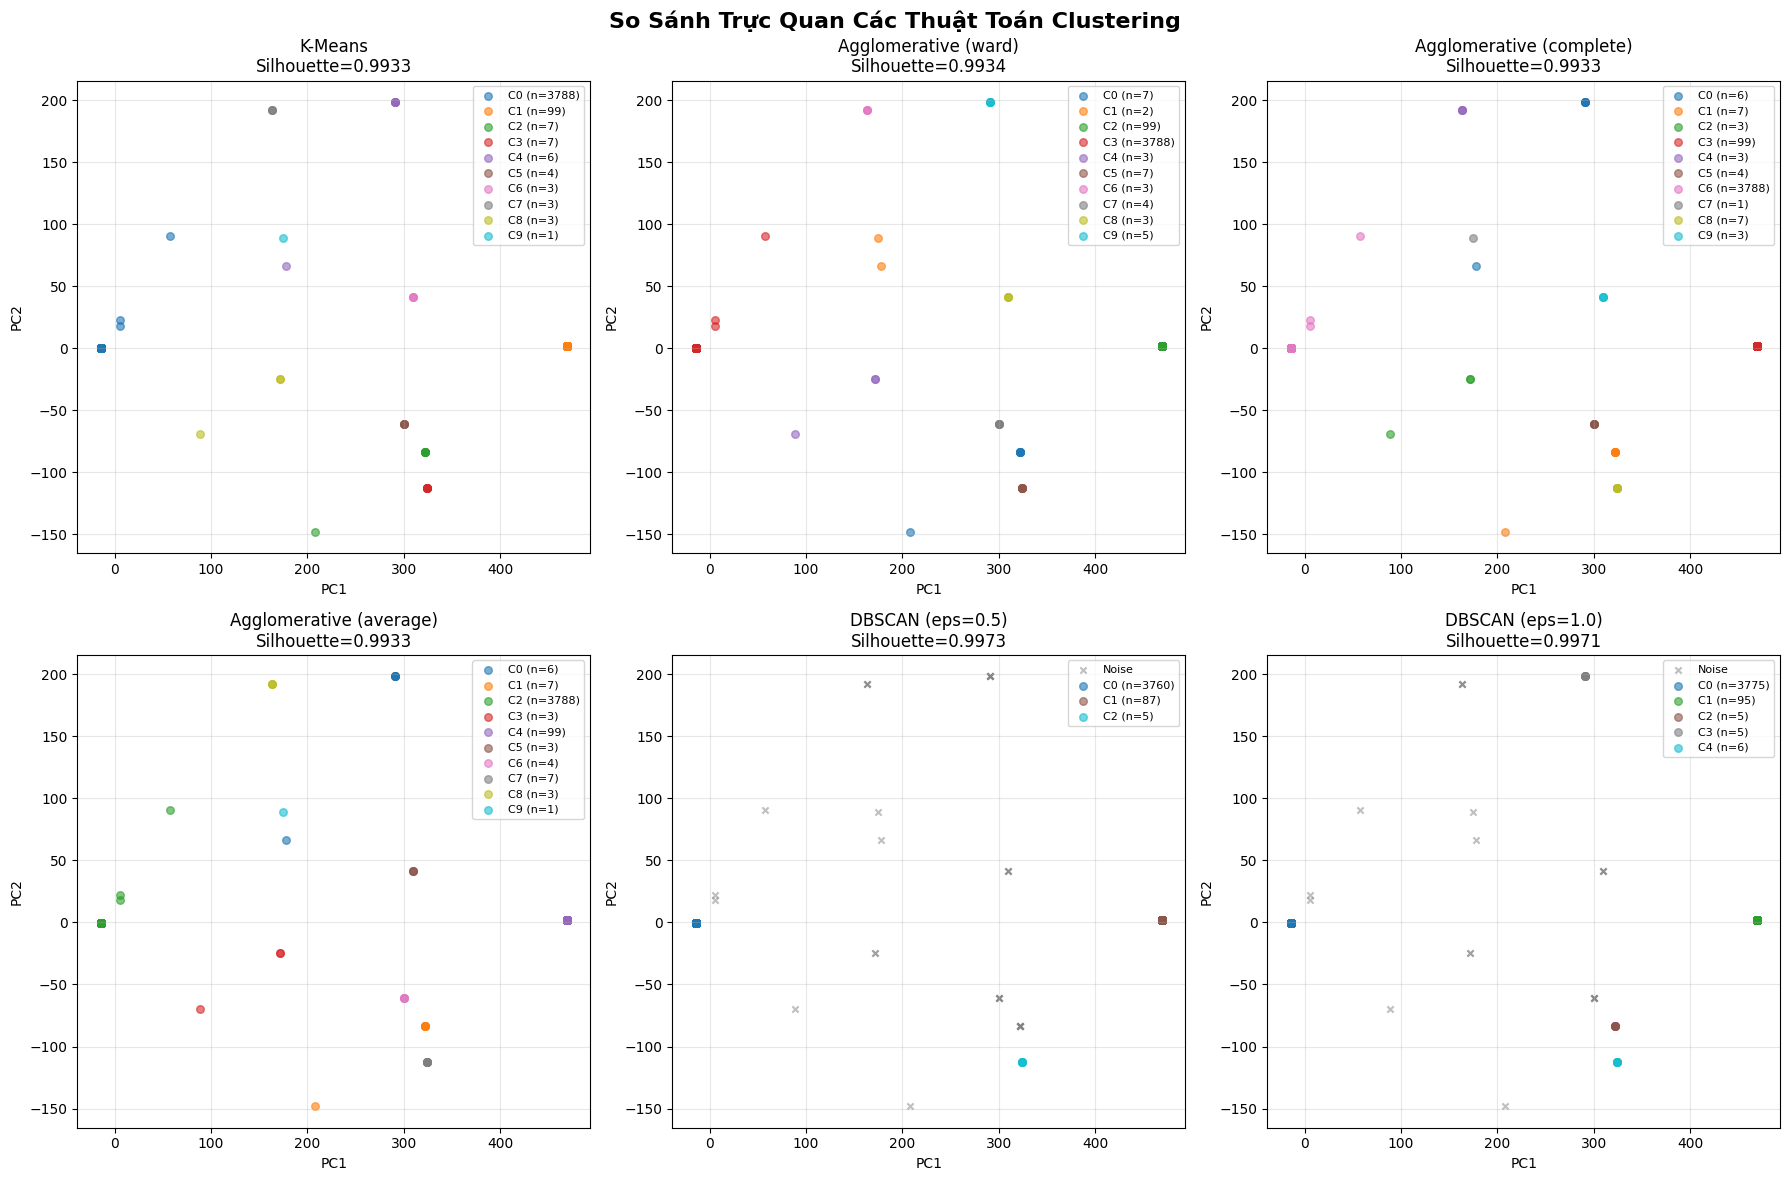


Saved: algorithm_comparison_visual.png


In [17]:
# Visualization: So sánh các thuật toán bằng PCA scatter
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Chọn top 5 thuật toán để visualize
top_algos = algo_results[:min(6, len(algo_results))]

for idx, result in enumerate(top_algos):
    ax = axes[idx]
    algo_labels = result["Labels"]
    algo_name = result["Algorithm"]
    sil = result["Silhouette"]
    
    # Màu cho từng cluster
    unique_labels = sorted(set(algo_labels))
    n_clusters = len([l for l in unique_labels if l != -1])
    colors_map = plt.cm.tab10(np.linspace(0, 1, max(n_clusters, 1)))
    
    for label in unique_labels:
        mask = algo_labels == label
        if label == -1:
            # Noise points (DBSCAN)
            ax.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                      c='gray', marker='x', s=20, alpha=0.5, label='Noise')
        else:
            color_idx = label % len(colors_map)
            ax.scatter(coords_2d[mask, 0], coords_2d[mask, 1],
                      c=[colors_map[color_idx]], s=30, alpha=0.6,
                      label=f'C{label} (n={mask.sum()})')
    
    ax.set_title(f"{algo_name}\nSilhouette={sil:.4f}", fontsize=12)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Ẩn axes thừa
for idx in range(len(top_algos), len(axes)):
    axes[idx].axis('off')

plt.suptitle("So Sánh Trực Quan Các Thuật Toán Clustering", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "algorithm_comparison_visual.png"), dpi=150, bbox_inches="tight")
plt.show()

print(f"\nSaved: algorithm_comparison_visual.png")

In [18]:
# Phân tích và kết luận so sánh thuật toán
print("=" * 70)
print("PHÂN TÍCH SO SÁNH THUẬT TOÁN")
print("=" * 70)

# Tìm thuật toán tốt nhất theo từng metric
best_silhouette = algo_comparison_df.loc[algo_comparison_df["Silhouette"].idxmax()]
best_dbi = algo_comparison_df.loc[algo_comparison_df["Davies-Bouldin"].idxmin()]
best_ch = algo_comparison_df.loc[algo_comparison_df["Calinski-Harabasz"].idxmax()]

print("\n🏆 THUẬT TOÁN TỐT NHẤT THEO TỪNG METRIC:")
print(f"\n  📈 Silhouette Score cao nhất:")
print(f"     → {best_silhouette['Algorithm']} = {best_silhouette['Silhouette']}")

print(f"\n  📉 Davies-Bouldin Index thấp nhất:")
print(f"     → {best_dbi['Algorithm']} = {best_dbi['Davies-Bouldin']}")

print(f"\n  📊 Calinski-Harabasz Index cao nhất:")
print(f"     → {best_ch['Algorithm']} = {best_ch['Calinski-Harabasz']}")

# So sánh K-Means với Agglomerative
kmeans_row = algo_comparison_df[algo_comparison_df["Algorithm"] == "K-Means"].iloc[0]
agg_ward_row = algo_comparison_df[algo_comparison_df["Algorithm"] == "Agglomerative (ward)"]

print("\n" + "-" * 70)
print("📋 NHẬN XÉT:")
print("-" * 70)

print("""
1. K-MEANS vs AGGLOMERATIVE:
   • K-Means thường nhanh hơn và phù hợp với dữ liệu lớn
   • Agglomerative (Ward) cho kết quả tương tự K-Means vì cả hai đều
     minimize within-cluster variance
   • Agglomerative có ưu điểm: không cần chỉ định K trước, có thể xem
     dendrogram để chọn K hợp lý

2. DBSCAN:
   • DBSCAN dựa trên mật độ, tự động phát hiện outliers
   • Phù hợp khi clusters có hình dạng không đều
   • Nhạy cảm với tham số eps và min_samples
   • Với dữ liệu rule-based features (sparse), DBSCAN có thể không hiệu quả

3. KẾT LUẬN CHO DỰ ÁN NÀY:
   • K-Means là lựa chọn phù hợp nhất vì:
     - Silhouette score rất cao (>0.99)
     - Dễ diễn giải centroid của từng cluster
     - Phù hợp với dữ liệu customer segmentation
     - Clusters có xu hướng "hình cầu" trong không gian feature
""")

print("=" * 70)

PHÂN TÍCH SO SÁNH THUẬT TOÁN

🏆 THUẬT TOÁN TỐT NHẤT THEO TỪNG METRIC:

  📈 Silhouette Score cao nhất:
     → DBSCAN (eps=0.5) = 0.9973

  📉 Davies-Bouldin Index thấp nhất:
     → DBSCAN (eps=0.5) = 0.0027

  📊 Calinski-Harabasz Index cao nhất:
     → DBSCAN (eps=0.5) = 9995117.84

----------------------------------------------------------------------
📋 NHẬN XÉT:
----------------------------------------------------------------------

1. K-MEANS vs AGGLOMERATIVE:
   • K-Means thường nhanh hơn và phù hợp với dữ liệu lớn
   • Agglomerative (Ward) cho kết quả tương tự K-Means vì cả hai đều
     minimize within-cluster variance
   • Agglomerative có ưu điểm: không cần chỉ định K trước, có thể xem
     dendrogram để chọn K hợp lý

2. DBSCAN:
   • DBSCAN dựa trên mật độ, tự động phát hiện outliers
   • Phù hợp khi clusters có hình dạng không đều
   • Nhạy cảm với tham số eps và min_samples
   • Với dữ liệu rule-based features (sparse), DBSCAN có thể không hiệu quả

3. KẾT LUẬN CHO DỰ ÁN NÀY:
 

In [15]:
print("="*70)
print("BÁO CÁO TÓM TẮT - PHÂN CỤM KHÁCH HÀNG DỰA TRÊN LUẬT KẾT HỢP")
print("="*70)

print("\n" + "-"*70)
print("1. SO SÁNH HỆ THỐNG (Apriori vs FP-Growth, Binary vs Weighted, Top-K)")
print("-"*70)
display(comparison_df)

print("\n" + "-"*70)
print("2. CẤU HÌNH TỐT NHẤT")
print("-"*70)
print(f"  • Rules Source: {os.path.basename(BEST_RULES_PATH)}")
print(f"  • Weighting: {BEST_WEIGHTING}")
print(f"  • Top-K Rules: {BEST_TOP_K}")
print(f"  • Best K (clusters): {best_k}")
print(f"  • Silhouette Score: {best_sil:.4f}")

print("\n" + "-"*70)
print("3. SILHOUETTE TABLE")
print("-"*70)
display(sil_df.sort_values("silhouette", ascending=False))

print("\n" + "-"*70)
print("4. CLUSTER PROFILING (RFM)")
print("-"*70)
display(rfm_df)

print("\n" + "-"*70)
print("5. TOP RULES PER CLUSTER")
print("-"*70)
for p in profiles:
    print(f"\nCluster {p['Cluster']} ({p['Size_pct']}):")
    if "top_rules" in p:
        for i, r in enumerate(p["top_rules"][:3], 1):
            print(f"  {i}. {r['rule_str']} ({r['activation']*100:.1f}%)")

print("\n" + "-"*70)
print("6. PCA SCATTER")
print("-"*70)
print(f"  • PC1 explains: {var_explained[0]:.1%}")
print(f"  • PC2 explains: {var_explained[1]:.1%}")
print(f"  • Total variance: {sum(var_explained):.1%}")
print(f"  • Image saved: {OUTPUT_DIR}/pca_scatter.png")

print("\n" + "="*70)
print("HẾT BÁO CÁO TÓM TẮT")
print("="*70)

BÁO CÁO TÓM TẮT - PHÂN CỤM KHÁCH HÀNG DỰA TRÊN LUẬT KẾT HỢP

----------------------------------------------------------------------
1. SO SÁNH HỆ THỐNG (Apriori vs FP-Growth, Binary vs Weighted, Top-K)
----------------------------------------------------------------------


,Rules Source,Weighting,Top-K,Best K,Silhouette
0,FP-Growth,lift,50,10,0.9933
1,Apriori,lift,50,10,0.9933
2,FP-Growth,lift_x_conf,50,10,0.9929
3,Apriori,lift_x_conf,50,10,0.9929
4,Apriori,lift_x_conf,100,2,0.9356
5,FP-Growth,lift_x_conf,100,2,0.9356
6,FP-Growth,lift,100,2,0.9223
7,Apriori,lift,100,2,0.9223
8,FP-Growth,lift_x_conf,200,2,0.8914
9,Apriori,lift_x_conf,200,2,0.8914



----------------------------------------------------------------------
2. CẤU HÌNH TỐT NHẤT
----------------------------------------------------------------------
  • Rules Source: rules_fpgrowth_filtered.csv
  • Weighting: lift
  • Top-K Rules: 50
  • Best K (clusters): 10
  • Silhouette Score: 0.9933

----------------------------------------------------------------------
3. SILHOUETTE TABLE
----------------------------------------------------------------------


,k,silhouette
0,10,0.993279
1,9,0.993144
2,8,0.992677
3,7,0.992546
4,6,0.991636
5,5,0.989398
6,4,0.986798
7,2,0.986423
8,3,0.985536



----------------------------------------------------------------------
4. CLUSTER PROFILING (RFM)
----------------------------------------------------------------------


,Cluster,Size,Size %,Recency (mean),Frequency (mean),Monetary (mean)
0,0,3788,96.6%,93.26,4.04,1808.41
1,1,99,2.5%,59.48,25.38,21284.50
2,2,6,0.2%,37.17,9.83,3483.87
3,3,7,0.2%,82.29,3.57,1320.65
4,4,3,0.1%,92.00,3.00,521.39
5,5,7,0.2%,73.43,4.71,1538.35
6,6,4,0.1%,77.50,3.50,1242.10
7,7,3,0.1%,28.00,11.00,3883.74
8,8,3,0.1%,9.33,7.33,2774.11
9,9,1,0.0%,277.00,1.00,391.52



----------------------------------------------------------------------
5. TOP RULES PER CLUSTER
----------------------------------------------------------------------

Cluster 0 (96.6%):
  1. HERB MARKER BASIL → HERB MARKER ROSEMARY (0.1%)
  2. HERB MARKER MINT → HERB MARKER PARSLEY (0.1%)
  3. HERB MARKER MINT → HERB MARKER CHIVES  (0.1%)

Cluster 1 (2.5%):
  1. HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HERB MARKER THYME (100.0%)
  2. HERB MARKER MINT, HERB MARKER THYME → HERB MARKER ROSEMARY (100.0%)
  3. HERB MARKER MINT, HERB MARKER THYME → HERB MARKER PARSLEY (100.0%)

Cluster 2 (0.2%):
  1. HERB MARKER BASIL, HERB MARKER THYME → HERB MARKER ROSEMARY (100.0%)
  2. HERB MARKER BASIL, HERB MARKER ROSEMARY → HERB MARKER THYME (100.0%)
  3. HERB MARKER THYME → HERB MARKER ROSEMARY (100.0%)

Cluster 3 (0.2%):
  1. HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HERB MARKER THYME (100.0%)
  2. HERB MARKER MINT, HERB MARKER THYME → HERB MARKER ROSEMARY (100.0%)
  3. HERB MARKER MINT, HERB